In [2]:
import zipfile
import os

zip_path = "/content/archive (5).zip"   # Path to your zip file
extract_path = "/content/archive (5)"  # Output folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)


Unzipped to: /content/archive (5)


In [5]:
!pip install --upgrade kneed

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from kneed import KneeLocator
import matplotlib.pyplot as plt
import glob

import os

path_images = []
for dirname, _, filenames in os.walk('/content/archive (5)/photos_no_class'):
    for filename in filenames:
        if filename.endswith('.jpg'):
            found_image = os.path.join(dirname, filename)
            path_images.append(found_image)
len_images = len(path_images)
print('Total Images : ', len_images)

Total Images :  80


In [8]:
images = []
for i in range(len_images):
    read_image = imread(path_images[i])
    img = resize(read_image, (640, 640), order=0)
    images.append(img)

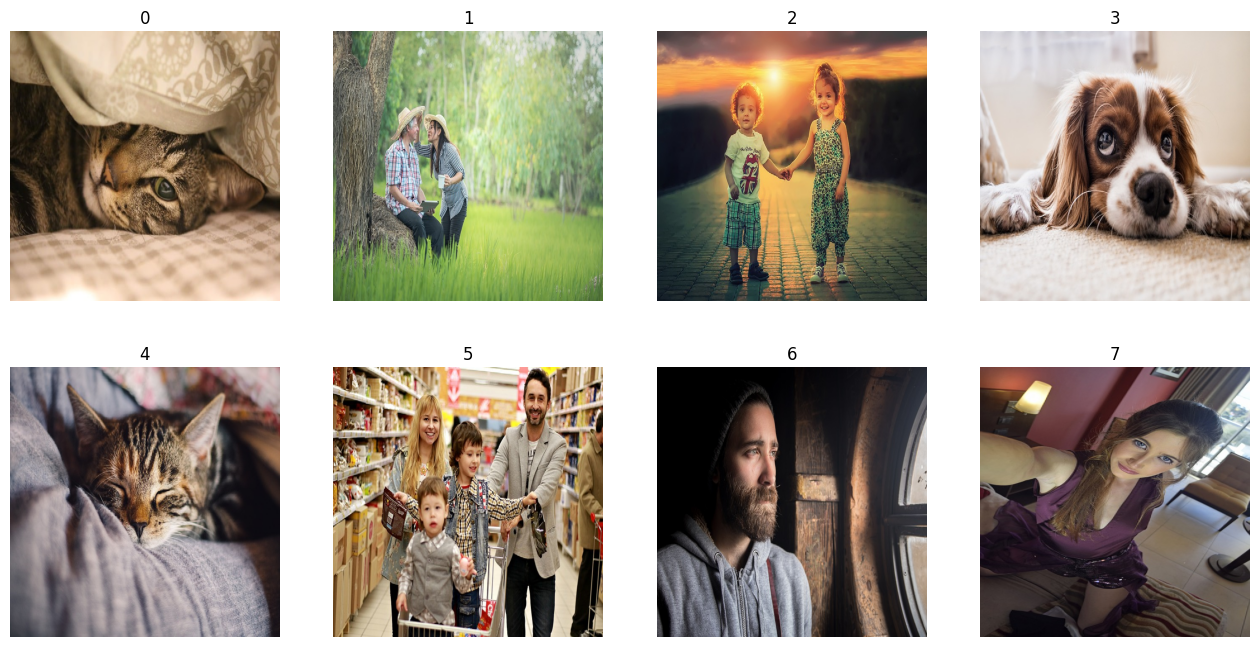

In [9]:
# Show Example Images
fig = plt.figure(figsize=(16, 8))

for i in range(8):
    fig.add_subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(i)

plt.show()

In [10]:
def feature_extraction(image):
    fd, hog_image = hog(image, orientations=9,
                        pixels_per_cell=(128, 128), cells_per_block=(2, 2),
                        visualize=True, channel_axis=-1)
    return fd, hog_image

In [11]:
feature_list = []
hog_image_list = []
for i in tqdm(range(len_images)):
    feature, hog_image = feature_extraction(images[i])

    feature_list.append(feature)
    hog_image_list.append(hog_image)

100%|██████████| 80/80 [00:12<00:00,  6.49it/s]


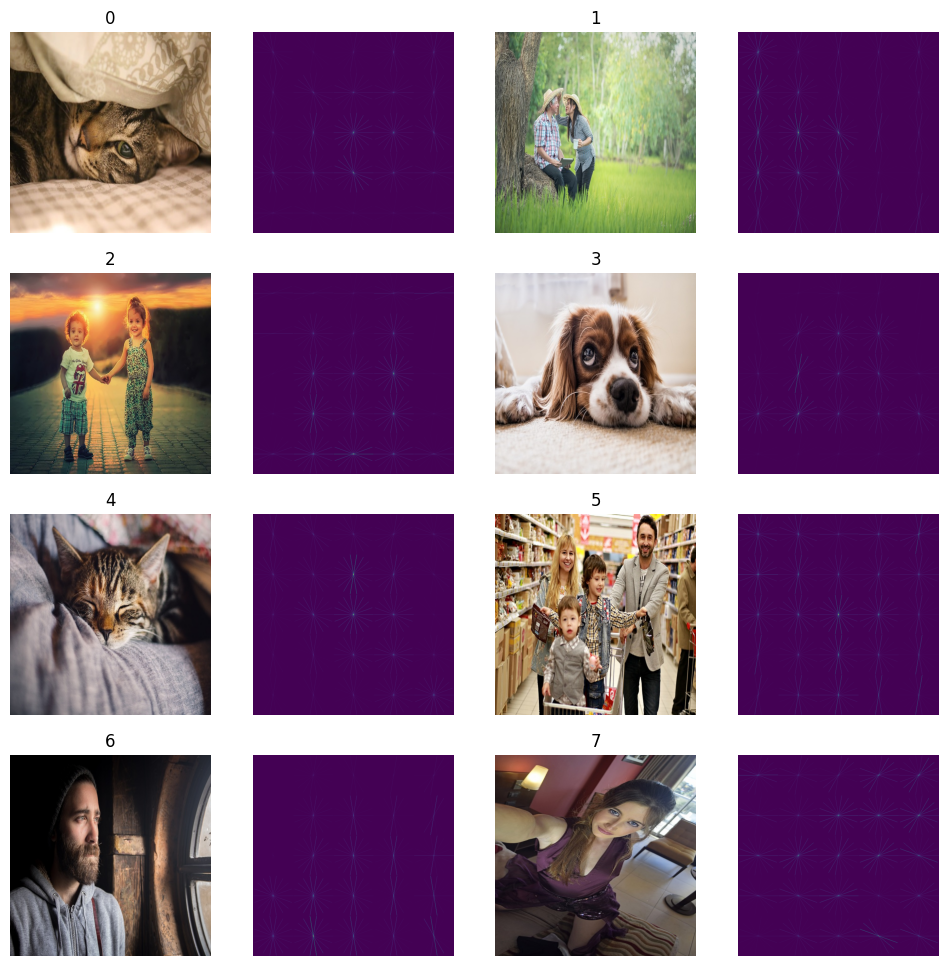

In [12]:
# Show Example Feature Extraction

fig = plt.figure(figsize=(12, 12))
k = 0
for i in range(8):
    # display hog image
    fig.add_subplot(4, 4, k+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(i)

    # display original image
    fig.add_subplot(4, 4, k+2)
    plt.imshow(hog_image_list[i])
    plt.axis("off")

    k += 2
plt.show()

In [13]:
# create an empty nxn distance matrix
distance_matrix = np.zeros((len_images, len_images))

for i in range(len_images):
    fd_i = feature_list[i]
    for k in range(i):
        fd_k = feature_list[k]
        # measure Jensen–Shannon distance between each feature vector
        # and add to the distance matrix
        distance_matrix[i, k] = distance.jensenshannon(fd_i, fd_k)

# symmetrize the matrix as distance matrix is symmetric
distance_matrix = np.maximum(distance_matrix, distance_matrix.transpose())

distance_matrix

array([[0.        , 0.24642617, 0.28219457, ..., 0.1875058 , 0.22026316,
        0.23390663],
       [0.24642617, 0.        , 0.34124607, ..., 0.19455086, 0.23735633,
        0.25396769],
       [0.28219457, 0.34124607, 0.        , ..., 0.23447959, 0.26788289,
        0.27741151],
       ...,
       [0.1875058 , 0.19455086, 0.23447959, ..., 0.        , 0.16463459,
        0.17780456],
       [0.22026316, 0.23735633, 0.26788289, ..., 0.16463459, 0.        ,
        0.15832993],
       [0.23390663, 0.25396769, 0.27741151, ..., 0.17780456, 0.15832993,
        0.        ]])

In [14]:
# convert square-form distance matrix to vector-form distance vector (condensed distance matrix)
cond_distance_matrix = distance.squareform(distance_matrix)

cond_distance_matrix

array([0.24642617, 0.28219457, 0.22425066, ..., 0.16463459, 0.17780456,
       0.15832993])

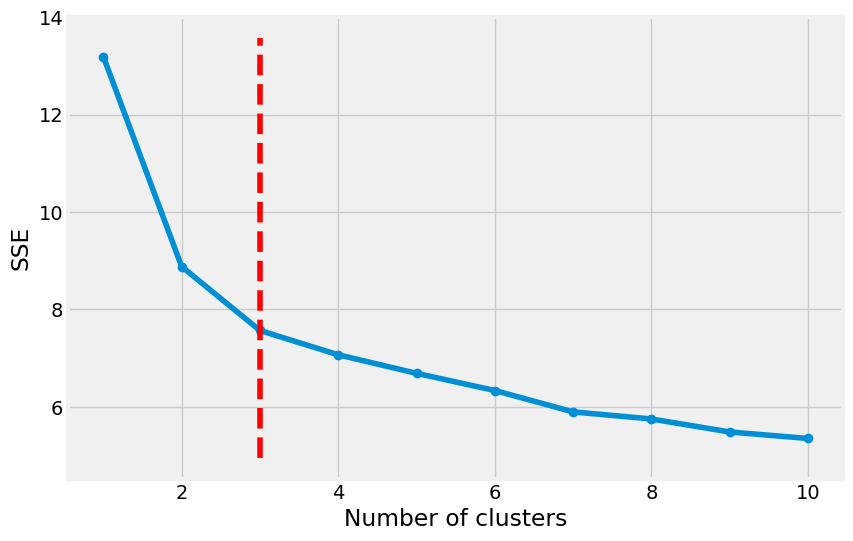

In [15]:
sse_kmeans = []
plt.figure(figsize=(10,6))
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(distance_matrix)
    sse_kmeans.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse_kmeans, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

ymin, ymax = plt.ylim()
kl = KneeLocator(range(1, 11), sse_kmeans, curve='convex', direction='decreasing')
plt.vlines(kl.elbow, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')

plt.show()

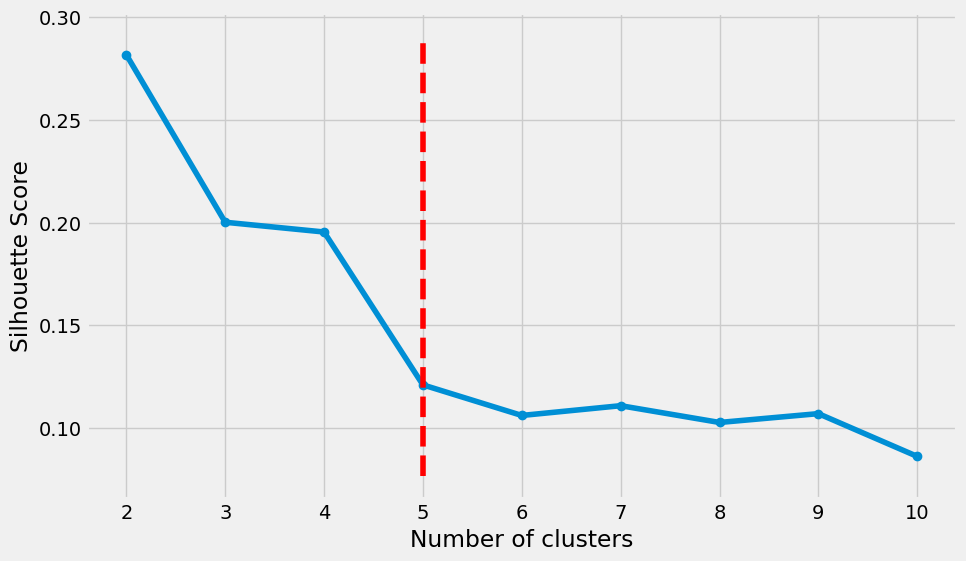

In [16]:
silhouette_scores_kmeans = []
plt.figure(figsize=(10,6))
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(distance_matrix)
    score = silhouette_score(distance_matrix, kmeans.labels_)
    silhouette_scores_kmeans.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

ymin, ymax = plt.ylim()
kl = KneeLocator(range(2, 11), silhouette_scores_kmeans, curve='convex', direction='decreasing')
plt.vlines(kl.elbow, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')

plt.show()

In [19]:
def display_images(image_paths):
    # Calculate the number of rows and columns for the subplot grid
    num_images = len(image_paths)
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows based on num_cols

    # Calculate a dynamic figsize based on your desired aspect ratio
    aspect_ratio = 16 / 9  # Adjust this ratio as needed
    fig_width = 12  # Adjust this width as needed
    fig_height = fig_width / aspect_ratio * num_rows / 3  # Adjust 3 for vertical space per row

    # Create the subplot grid with dynamic figsize
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    # Loop through the image filenames and display them in subplots
    for i, filename in enumerate(image_paths):
        row = i // num_cols
        col = i % num_cols
        img = imread(filename)
        axs[row, col].imshow(img)
        axs[row, col].axis('off')

    # Hide any empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

In [20]:
kmeans = KMeans(n_clusters = kl.elbow, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(distance_matrix)

In [21]:
groups_kmeans = {}
for file, cluster in zip(path_images, clusters):
    if cluster not in groups_kmeans.keys():
        groups_kmeans[cluster] = []
        groups_kmeans[cluster].append(file)
    else:
        groups_kmeans[cluster].append(file)

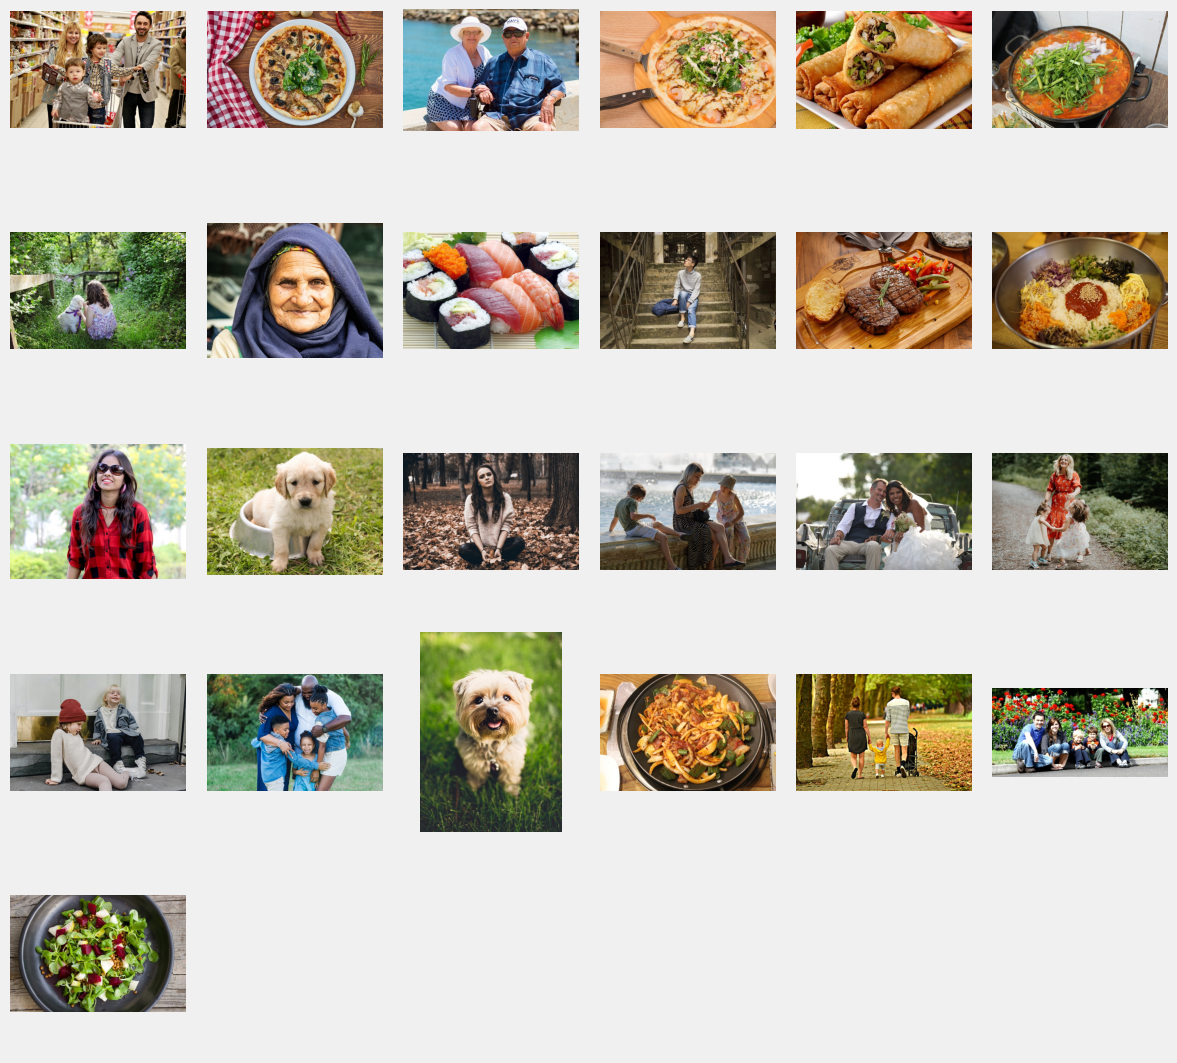

In [22]:
display_images(groups_kmeans[0])

/usr/local/lib/python3.12/dist-packages/scipy/cluster/hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.12/dist-packages/scipy/cluster/hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.12/dist-packages/scipy/cluster/hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.12/dist-packages/scipy/cluster/hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidea

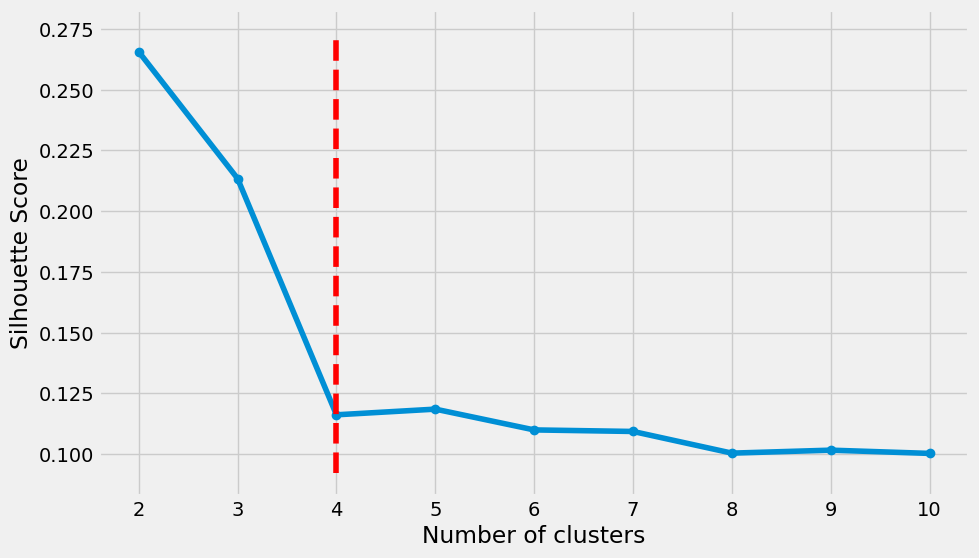

In [23]:
silhouette_scores_agglo_clust = []
plt.figure(figsize=(10,6))
for i in range(2, 11):
    agglo_clust = AgglomerativeClustering(n_clusters = i, metric = 'euclidean', linkage = 'ward')
    agglo_clust.fit(distance_matrix)
    score = silhouette_score(distance_matrix, agglo_clust.labels_)
    silhouette_scores_agglo_clust.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_scores_agglo_clust, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

ymin, ymax = plt.ylim()
kl = KneeLocator(range(2, 11), silhouette_scores_agglo_clust, curve='convex', direction='decreasing')
plt.vlines(kl.elbow, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')

plt.show()

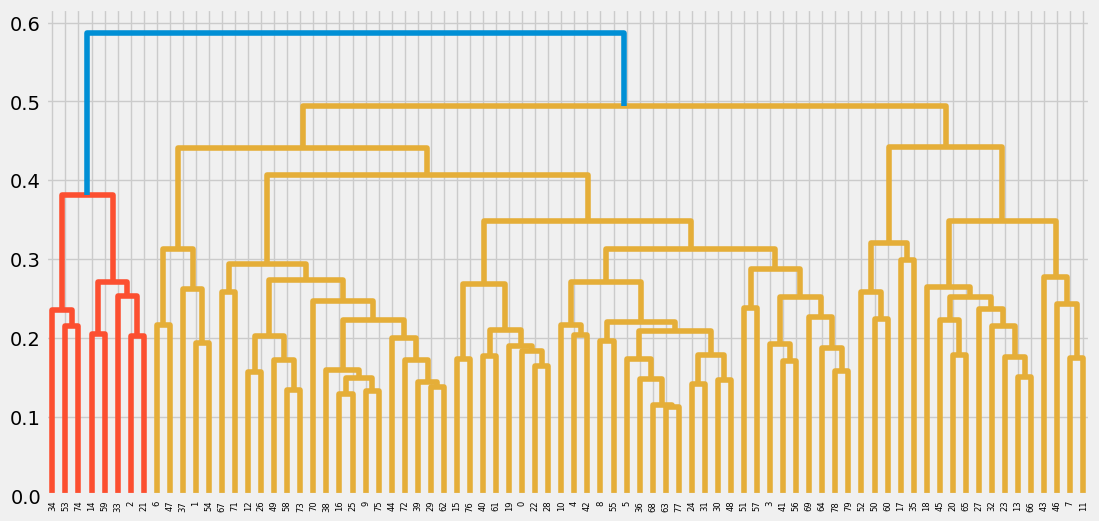

In [24]:
Z = linkage(cond_distance_matrix, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, color_threshold=0.5, show_leaf_counts=True)
plt.show()

In [25]:
agglo_clust = AgglomerativeClustering(n_clusters = kl.elbow, metric = 'euclidean', linkage = 'ward')
clusters = agglo_clust.fit_predict(distance_matrix)

/usr/local/lib/python3.12/dist-packages/scipy/cluster/hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [26]:
groups_hierarchical = {}
for file, cluster in zip(path_images, clusters):
    if cluster not in groups_hierarchical.keys():
        groups_hierarchical[cluster] = []
        groups_hierarchical[cluster].append(file)
    else:
        groups_hierarchical[cluster].append(file)

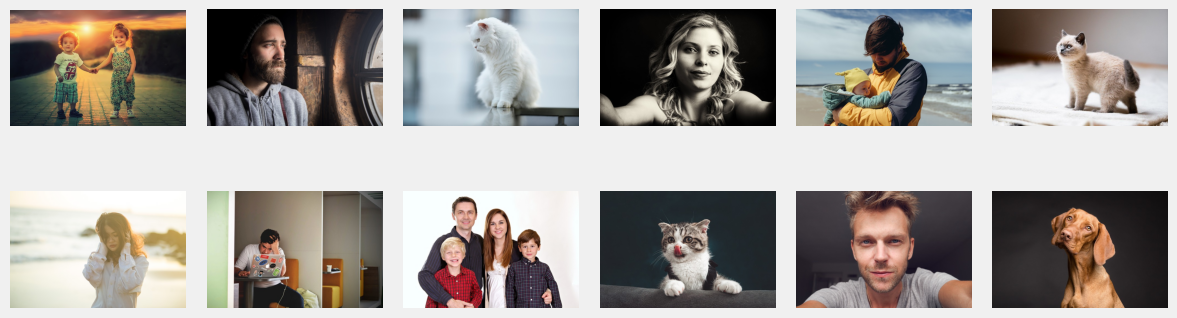

In [27]:
display_images(groups_hierarchical[0])